In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import warnings
warnings.simplefilter('ignore')

In [2]:
url = "https://datadocs.bco-dmo.org/file/OJRrAA6hpQREv3/3782_v6_bats_bottle.csv"
df = pd.read_csv(url)
df.head(2)

,ISO_DateTime_UTC,Bottle_ID,Latitude,Longitude,Vessel,Cruise_ID,Cruise_type,Cruise_num,Cast_num,Bottle_num,...,QF25_Prochloro,Synechococcus,QF26_Synecho,Picoeukaryotes,QF27_Picoeuks,Nanoeukaryotes,QF28_Nanoeuks,yyyymmdd,time,decimal_year
0,1988-10-20T22:30Z,1000100112,31.783,-64.116,R/V Weatherbird I,10001,BATS Core,1,1,12,...,9,NaN,9,NaN,9,NaN,9,19881020,2230,1988.80311
1,1988-10-20T22:30Z,1000100111,31.783,-64.116,R/V Weatherbird I,10001,BATS Core,1,1,11,...,9,NaN,9,NaN,9,NaN,9,19881020,2230,1988.80311


In [4]:
df['ISO_DateTime_UTC'] = pd.to_datetime(df['ISO_DateTime_UTC'],errors="coerce")#.astype('datetime64[s]')
df.head(2)

,ISO_DateTime_UTC,Bottle_ID,Latitude,Longitude,Vessel,Cruise_ID,Cruise_type,Cruise_num,Cast_num,Bottle_num,...,QF25_Prochloro,Synechococcus,QF26_Synecho,Picoeukaryotes,QF27_Picoeuks,Nanoeukaryotes,QF28_Nanoeuks,yyyymmdd,time,decimal_year
0,1988-10-20 22:30:00+00:00,1000100112,31.783,-64.116,R/V Weatherbird I,10001,BATS Core,1,1,12,...,9,NaN,9,NaN,9,NaN,9,19881020,2230,1988.80311
1,1988-10-20 22:30:00+00:00,1000100111,31.783,-64.116,R/V Weatherbird I,10001,BATS Core,1,1,11,...,9,NaN,9,NaN,9,NaN,9,19881020,2230,1988.80311


In [163]:
def make_depth_datasets(df, depths, time='ISO_DateTime_UTC'):
    
    datasets = {}
    
    for min_depth, max_depth, label in depths:

        filtered = df[(df['Depth'] >= min_depth) & (df['Depth'] <= max_depth)].copy()
        
        filtered['YearMonth'] = filtered[time].dt.to_period('M')
        filtered['Month'] = filtered[time].dt.month
        filtered['Year'] = filtered[time].dt.year
        
        datasets[label] = filtered
        
    return datasets

In [164]:
depth_ranges = [
    (0, 50, 'Surface'),
    (50, 200, 'Mid-depth'),
    (200, 400, 'Deep'),
    # Add more ranges as needed
]
datasets = make_depth_datasets(df, depth_ranges)

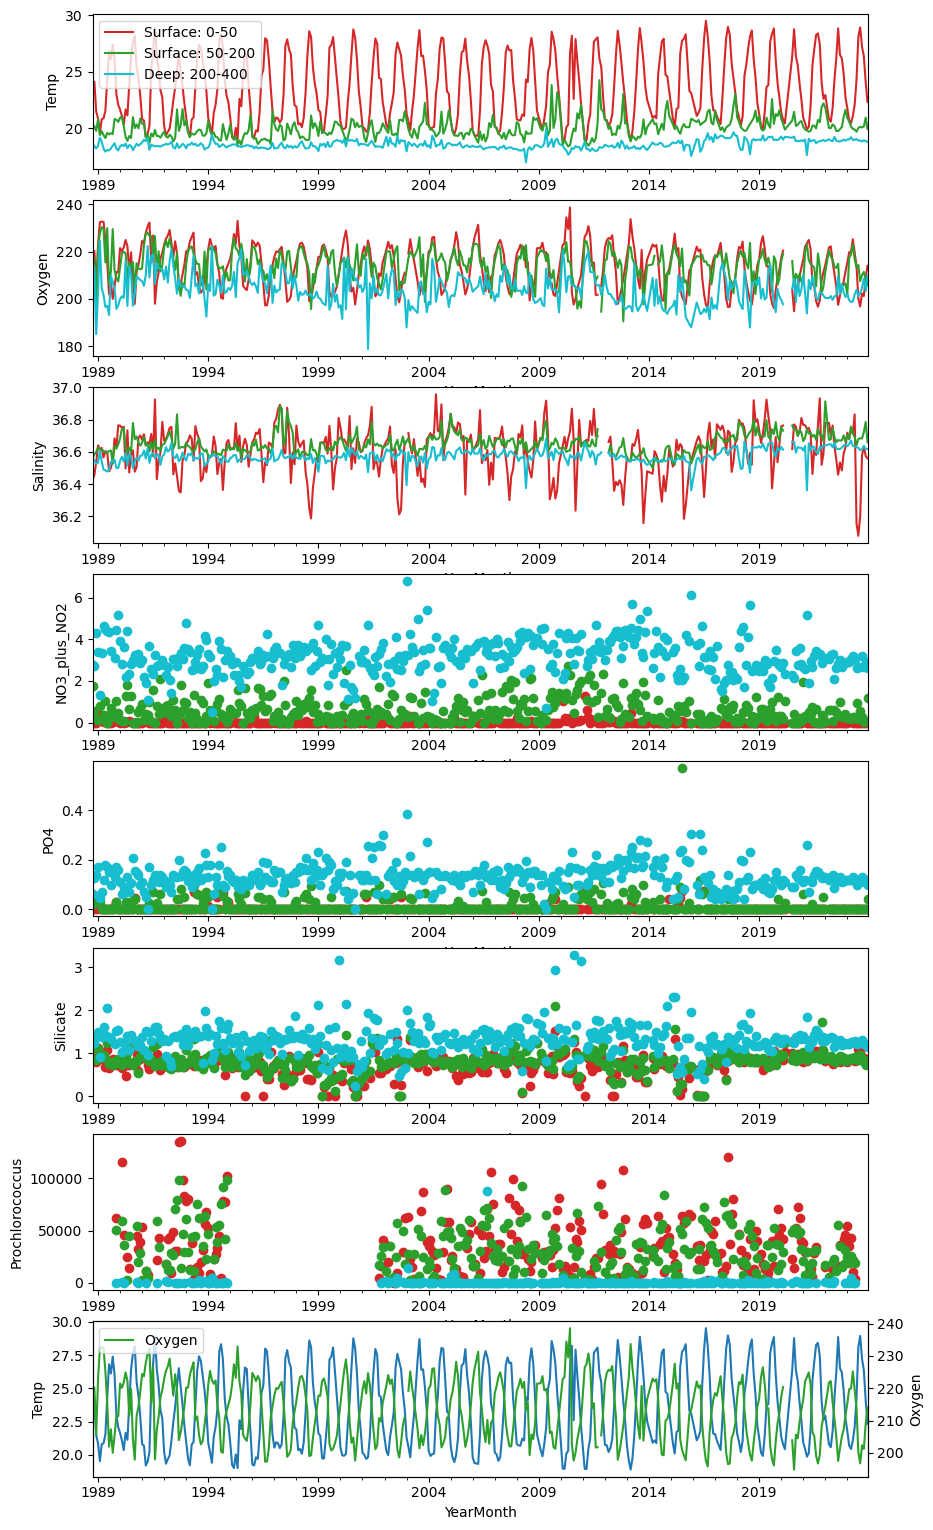

In [173]:
plt.figure(figsize=(10,19))
plt.subplot(8,1,1)

#datasets['Surface'].groupby("ISO_DateTime_UTC")["Temp"].median().plot()
datasets['Surface'].groupby('YearMonth')["Temp"].median().plot(color='C3',label=f"Surface: {int(datasets['Surface'].Depth.min())}-{int(datasets['Surface'].Depth.max())}")
datasets['Mid-depth'].groupby('YearMonth')["Temp"].median().plot(color='C2',label=f"Surface: {int(datasets['Mid-depth'].Depth.min())}-{int(datasets['Mid-depth'].Depth.max())}")
datasets['Deep'].groupby('YearMonth')["Temp"].median().plot(color='C9',label=f"Deep: {int(datasets['Deep'].Depth.min())}-{int(datasets['Deep'].Depth.max())}")
plt.ylabel("Temp")
plt.legend(loc=2)

plt.subplot(8,1,2)
datasets['Surface'].groupby('YearMonth')["Oxygen"].median().plot(color='C3')
datasets['Mid-depth'].groupby('YearMonth')["Oxygen"].median().plot(color='C2')
datasets['Deep'].groupby('YearMonth')["Oxygen"].median().plot(color='C9')
plt.ylabel("Oxygen")
# plt.legend(loc=2)

plt.subplot(8,1,3)
datasets['Surface'].groupby('YearMonth')["Salinity"].median().plot(color='C3')
datasets['Mid-depth'].groupby('YearMonth')["Salinity"].median().plot(color='C2')
datasets['Deep'].groupby('YearMonth')["Salinity"].median().plot(color='C9')
plt.ylabel("Salinity")
# plt.legend(loc=2)


plt.subplot(8,1,4)
datasets['Surface'].groupby('YearMonth')["NO3_plus_NO2"].median().plot(marker="o", linestyle="",color='C3')
datasets['Mid-depth'].groupby('YearMonth')["NO3_plus_NO2"].median().plot(marker="o", linestyle="",color='C2')
datasets['Deep'].groupby('YearMonth')["NO3_plus_NO2"].median().plot(marker="o", linestyle="",color='C9')
plt.ylabel("NO3_plus_NO2")
# plt.legend(loc=2)


plt.subplot(8,1,5)
datasets['Surface'].groupby('YearMonth')["PO4"].median().plot(marker="o", linestyle="",color='C3')
datasets['Mid-depth'].groupby('YearMonth')["PO4"].median().plot(marker="o", linestyle="",color='C2')
datasets['Deep'].groupby('YearMonth')["PO4"].median().plot(marker="o", linestyle="",color='C9')
plt.ylabel("PO4")
# plt.legend(loc=2)


plt.subplot(8,1,6)
datasets['Surface'].groupby('YearMonth')["Silicate"].median().plot(marker="o", linestyle="",label="",color='C3')
datasets['Mid-depth'].groupby('YearMonth')["Silicate"].median().plot(marker="o", linestyle="",label="",color='C2')
datasets['Deep'].groupby('YearMonth')["Silicate"].median().plot(marker="o", linestyle="",label="",color='C9')
plt.ylabel("Silicate")
# plt.legend(loc=2)


plt.subplot(8,1,7)
datasets['Surface'].groupby('YearMonth')["Prochlorococcus"].median().plot(marker="o", linestyle="",label="",color='C3')
datasets['Mid-depth'].groupby('YearMonth')["Prochlorococcus"].median().plot(marker="o", linestyle="",label="",color='C2')
datasets['Deep'].groupby('YearMonth')["Prochlorococcus"].median().plot(marker="o", linestyle="",label="",color='C9')
plt.ylabel("Prochlorococcus")
# plt.legend(loc=2)


plt.subplot(8,1,8)
ax1 = plt.gca()  # Get the current axis
datasets['Surface'].groupby('YearMonth')["Temp"].median().plot(ax=ax1, color="tab:blue", label="Temp")
ax1.set_ylabel("Temp")
ax2 = ax1.twinx()
datasets['Surface'].groupby('YearMonth')["Oxygen"].median().plot(ax=ax2, color="tab:green",label="Oxygen")
ax2.set_ylabel("Oxygen")
plt.legend(loc=2)

(345.0, 420.0)

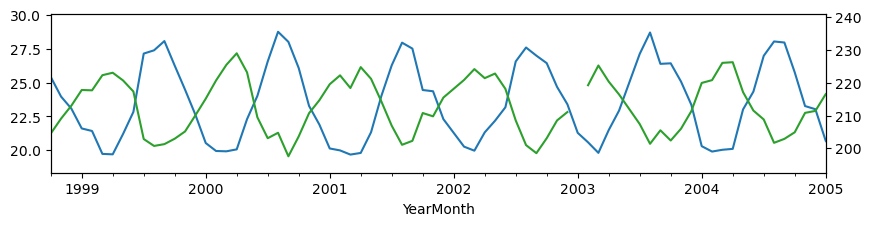

In [175]:
plt.figure(figsize=(10, 7))

# Main subplot
plt.subplot(3, 1, 1)

# Create the left y-axis for Temperature
ax1 = plt.gca()  # Get the current axis
datasets['Surface'].groupby('YearMonth')["Temp"].median().plot(ax=ax1, color="tab:blue")

# Create the right y-axis for Oxygen
ax2 = ax1.twinx()  # Create a twin y-axis
datasets['Surface'].groupby('YearMonth')["Oxygen"].median().plot(ax=ax2, color="tab:green")
plt.xlim(df.ISO_DateTime_UTC.values[10*1300],df.ISO_DateTime_UTC.values[10*2100])

In [176]:
def create_parameter_plots(datasets, param_config, layout=None, figsize=(14, 32)):

    n_params = len(param_config)
    n_datasets = len(datasets)

    if layout is None:
        layout = (n_params, n_datasets)
    
    rows, cols = layout

    fig = plt.figure(figsize=figsize)

    for param_idx, (param, config) in enumerate(param_config.items()):

        for dataset_idx, (df, label) in enumerate(datasets):

            plot_idx = param_idx * cols + dataset_idx + 1

            plt.subplot(rows, cols, plot_idx)

            data = df.query(config['query']) if config.get('query') else df

            if config.get('type', 'box') == 'line':
                sns.lineplot(data=data, 
                           x=config.get('x', 'Month'), 
                           y=param,
                           hue=config.get('hue'),
                           legend=config.get('legend', False))
            else:
                sns.boxplot(data=data, 
                          x=config.get('x', 'Month'), 
                          y=param,
                          legend=config.get('legend', False))

            if config.get('log_scale'):
                plt.yscale("log")

            ylim = config.get('ylim')
            if isinstance(ylim, dict):
                depth_ylim = ylim.get(label)
                if depth_ylim:
                    plt.ylim(depth_ylim)
            elif ylim:
                plt.ylim(ylim)
                
            if config.get('xlim'):
                plt.xlim(config.get('xlim'))
            
            # # Add labels if provided
            # if config.get('title'):
            #     plt.title(f"{config['title']} - {label}")
            # if config.get('xlabel'):
            #     plt.xlabel(config['xlabel'])
            # if config.get('ylabel'):
            #     plt.ylabel(config['ylabel'])
            
    plt.subplots_adjust(
        hspace=config.get('hspace', 0.09), 
        wspace=config.get('wspace', 0.2)
    )
    
    return fig

In [177]:
param_config = {
   'Temp': {
       'type': 'line',
       'ylim': {
           'Surface':[16,30],
           'Mid-depth':[16,30],
           'Deep':[16,30]
       },
       'xlim': [1, 12],
       'hue': 'Year',
       'title': ''
   },
   'NO3_plus_NO2': {
       'type': 'box', 
       'query': 'NO3_plus_NO2>0', #[0.03, 1.3]
       'ylim': {
           'Surface':[0.02,6],
           'Mid-depth':[0.02,6],
           'Deep':[0.02, 6]
       },
       'xlim': None,
       'title': ''
   },
   'PO4': {
       'type': 'box',
       'query': 'PO4>0', 
       'ylim': {
           'Surface':[0.02, 0.25],
           'Mid-depth':[0.02, 0.25],
           'Deep':[0.02,0.25]
       },
       'xlim': None,
       'title': ''#
   },
   'Silicate': {
       'type': 'box',
       'query': 'Silicate>0',
       'ylim': [0.5, 1.8],
       'xlim': None,
       'title': ''
   },
   'Prochlorococcus': {
       'type': 'box',
       'query': 'Prochlorococcus>0',
       'ylim': [0, 12e4],
       'xlim': None,
       'title': ''
   },
   'Oxygen': {
       'type': 'box',
       'ylim': [190, 240],
       'xlim': None,
       'title': ''
   },
   'CO2': {
       'type': 'box',
       'ylim': [2020, 2130],
       'xlim': None,
       'title': ''
   }
}
#plt.ylim([2080,2130])
# common_settings = {
#    'legend': False,
#    'xlabel': 'Month',
#    'wspace': 0.2,
#    'hspace': 0.13
# }

# for param in param_config:
#    param_config[param].update(common_settings)

In [178]:
plot_datasets = [(df, label) for label, df in datasets.items()]

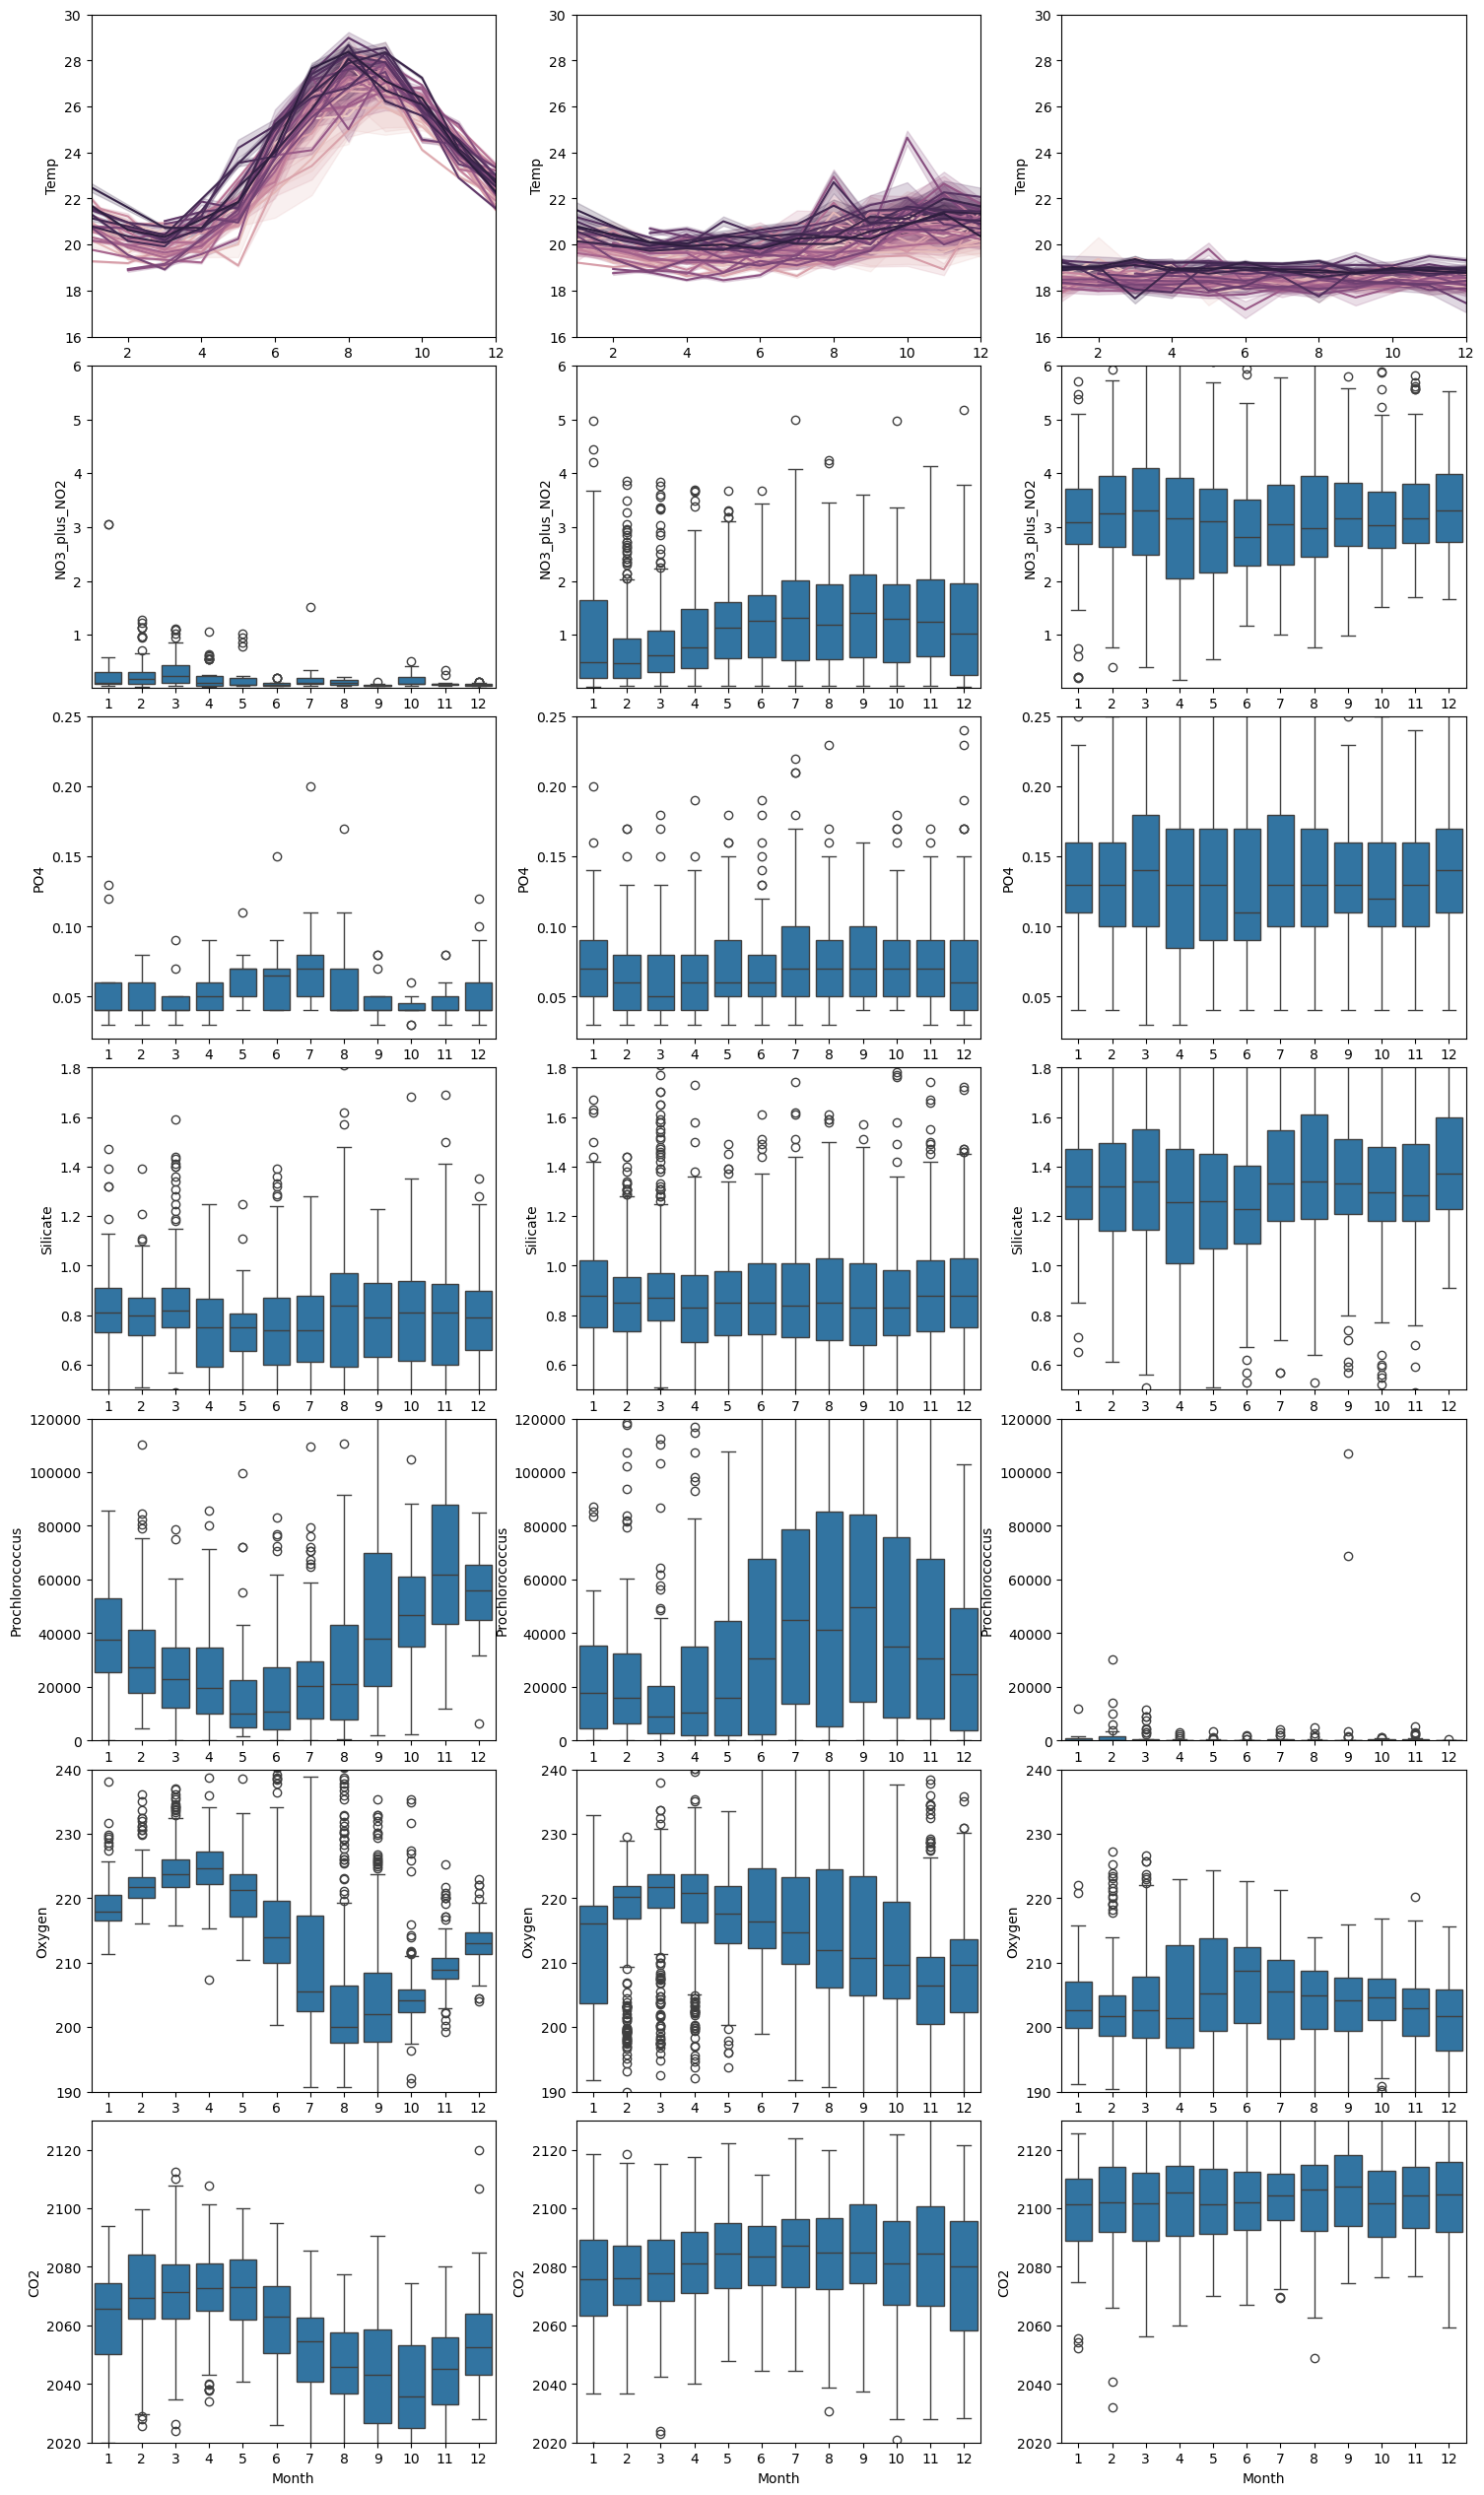

In [179]:
fig = create_parameter_plots(
    datasets=plot_datasets,
    param_config=param_config,
    layout=(7, 3),
    figsize=(18, 32)
)

plt.show()

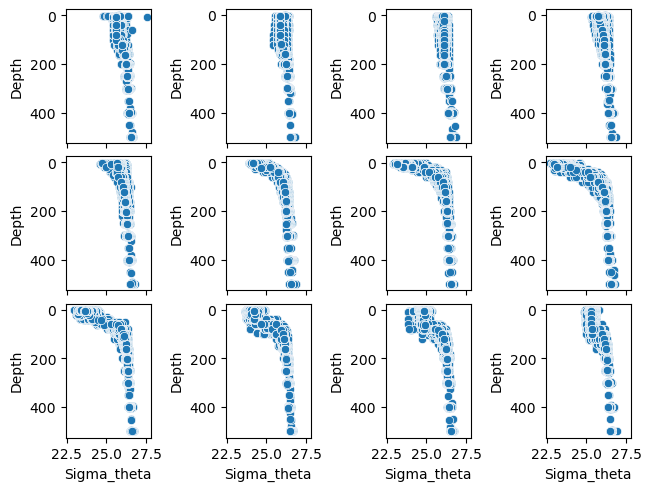

In [180]:
filtered_df = df[(df['Depth'] >= 0) & (df['Depth'] <= 500)]
filtered_df['YearMonth'] = filtered_df['ISO_DateTime_UTC'].dt.to_period('M')
filtered_df['Month'] = filtered_df['ISO_DateTime_UTC'].dt.month

sigma_df = filtered_df
sigma_df["YearMonth"] = filtered_df["YearMonth"]
sigma_df["Month"] = sigma_df["YearMonth"].dt.month
sigma_df["Year"] = sigma_df["YearMonth"].dt.year


#sns.scatterplot(data=sigma_df, x = "Sigma_theta", y = "Depth", hue = "Month").invert_yaxis()

fig, ax = plt.subplots(nrows = 3, ncols = 4, sharey = "col", sharex = "all", layout = "constrained")
for i, month in enumerate(sorted((sigma_df.Month).unique())):
    col = i%4
    if i < 4:
        row = 0
    elif i < 8:
        row = 1
    else:
        row = 2
    
    sns.scatterplot(data=sigma_df[sigma_df.Month == month], x = "Sigma_theta", y = "Depth", ax = ax[row, col]).invert_yaxis()
    #[col.invert_yaxis() for col in ax[0]]